In [47]:
import numpy as np
import pandas as pd
import math
import time
import re
import os
from skimage import util
from scipy.io import wavfile
from scipy import signal
from scipy import stats
import xarray as xr

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, accuracy_score


from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score
from sklearn.decomposition import PCA

#visualizing results
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Create data frame of annotation info

In [49]:
features_path = 'C:/Users/Schindler/Documents/ProgrammingFun/USV_python/annot_features_full.csv'
annot_features_data = pd.read_csv(features_path)
annot_features_full = pd.DataFrame(data = annot_features_data)
print(annot_features_full.shape)
print(annot_features_full.loc[pd.isna(annot_features_full['spec_pur'])].index)
annot_features_full.dropna(axis = 0, inplace=True)
print(annot_features_full.shape)
print(annot_features_full.loc[pd.isna(annot_features_full['spec_pur'])].index)
annot_features_full.head()

(1084, 8)
Int64Index([], dtype='int64')
(1084, 8)
Int64Index([], dtype='int64')


,Unnamed: 0,Animal,Group,Annotation,time_stamp,power_sum,spec_pur,spec_cent
0,0,533,5,low slug,46305.0,32714.904,0.368722,39977.722859
1,1,533,5,low slug,149692.5,43037.465,0.306856,37931.297174
2,2,533,5,low slug,243157.5,270193.530,0.062226,11483.575417
3,3,533,5,low slug,243270.0,63014.450,0.232295,32242.080548
4,4,533,5,low multi,295560.0,74933.164,0.206291,17095.059755


In [50]:
annot_features_full.groupby('Annotation').describe()

Unnamed: 0                                                              Animal                                                            Group                                              time_stamp                                                                                    power_sum                                                                                           spec_pur                                                                       spec_cent                                                                                                  
                count        mean         std    min     25%    50%     75%    max  count        mean        std    min    25%    50%    75%    max  count      mean       std  min  25%  50%  75%  max      count           mean            std      min        25%        50%         75%       max     count          mean           std        min           25%         50%          75%         max    count      mean       std       min       25%       50%       75%       max     count          mean           std           min           25%           50%           75%           max
Annotation                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
bbc              16.0   81.875000   26.181100   21.0   76.25   84.5  101.75  107.0   16.0  551.125000   8.724487  534.0  543.0  554.0  559.0  559.0   16.0  4.437500  0.512348  4.0  4.0  4.0  5.0  5.0       16.0  222723.281250  161859.049561  13590.0  117303.75  196908.75  301685.625  535702.5      16.0  2.040783e+05  1.933221e+05  65204.582  118303.71000  157959.005  179809.2375    872012.6     16.0  0.101816  0.046395  0.026119  0.085418  0.089934  0.118413  0.219365      16.0  31369.661607   3408.032120  25428.290568  29530.387688  31273.059203  33965.215906  36864.115098
high multi        5.0   60.800000   34.981424   10.0   53.00   56.0   82.00  103.0    5.0  543.200000  12.296341  533.0  535.0  535.0  554.0  559.0    5.0  4.800000  0.447214  4.0  5.0  5.0  5.0  5.0        5.0  302022.000000  170424.906515  57397.5  192375.00  379530.00  438345.000  442462.5       5.0  2.495828e+05  2.766522e+05  36262.824   82139.89000   85348.330  353085.7200    691077.3      5.0  0.178159  0.120824  0.047601  0.077175  0.207964  0.208621  0.349433       5.0  31143.298553  10637.140651  20439.491922  22611.237394  27829.758591  42347.084235  42488.920624
high slug         9.0   66.000000   29.664794   11.0   55.00   68.0   86.00  100.0    9.0  545.888889  10.658851  533.0  535.0  542.0  554.0  559.0    9.0  4.555556  0.527046  4.0  4.0  5.0  5.0  5.0        9.0  220312.500000  219288.402620   6727.5   22657.50  128407.50  395572.500  567112.5       9.0  2.744756e+05  2.536576e+05  33684.504   35585.75000  241675.030  423924.3000    668787.6      9.0  0.177870  0.146711  0.045738  0.051601  0.082861  0.354162  0.370857       9.0  30765.986009  15858.721043  13903.043684  16985.075190  28970.234673  46283.469560  55862.626347
low multi        17.0   45.176471   30.364937    4.0   24.00   30.0   72.00   91.0   17.0  539.352941   7.631687  533.0  535.0  535.0  542.0  554.0   17.0  4.647059  0.492592  4.0  4.0  5.0  5.0  5.0       17.0  244778.823529  208506.188963     90.0   23017.50  295560.00  455805.000  575505.0      17.0  3.931856e+05  3.583600e+05  45047.930  186790.48000  247730.560  512213.7200   1366219.0     17.0  0.097847  0.073801  0.027210  0.044896  0.079218  0.100473  0.297074      17.0  17385.064098   4301.340444  12501.794627 

In [51]:
annot_labels_full = annot_features_full['Annotation']

In [52]:
#separate and save for later testing dataset
X_train, X_test, y_train, y_test = train_test_split(annot_features_full, annot_labels_full, test_size=0.3, random_state=1, stratify = annot_labels_full)

In [53]:
y_train.replace(regex={r'low slug': 1, 'high slug': 1, 'low multi': 1, 'high multi': 1, 'bbc': 1, 'noise': 0, 'rand_noise': 0}, inplace=True)

In [54]:
y_train.value_counts()

0    682
1     76
Name: Annotation, dtype: int64

In [55]:
annot_features = X_train[['power_sum', 'spec_pur', 'spec_cent']]
annot_features.head()

,power_sum,spec_pur,spec_cent
715,38291.895,0.341985,43326.606692
614,75516.050,0.307858,38593.783622
1082,51068.047,0.014144,11387.090700
885,82732.984,0.153284,20069.902907
743,27597.244,0.434002,46654.941206


In [56]:
# center and scale the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(annot_features)

In [57]:
#skf = StratifiedKFold(n_splits=3)
#lr_cv.fit(features_scaled, annot_labels)
#print("Test set accuracy of LR model: ",lr_cv.score(features_scaled, annot_labels))

lr_cv = LogisticRegression(random_state=0)

y_pred = cross_val_predict(lr_cv, features_scaled, y_train, cv=3, method='predict')
y_pred_prob = cross_val_predict(lr_cv, features_scaled, y_train, cv=3, method='predict_proba')
conf_mat = confusion_matrix(y_train, y_pred)
conf_mat

C:\Users\Schindler\AppData\Local\conda\conda\envs\USV_python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Schindler\AppData\Local\conda\conda\envs\USV_python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Schindler\AppData\Local\conda\conda\envs\USV_python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Schindler\AppData\Local\conda\conda\envs\USV_python\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Schindler\AppData\Local

array([[682,   0],
       [ 76,   0]], dtype=int64)

In [58]:
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(y_train,y_pred))
print("Precision (PPV): ", metrics.precision_score(y_train,y_pred))
print("Accuracy: ", metrics.accuracy_score(y_train,y_pred))
print("F1:", metrics.f1_score(y_train,y_pred))

Sensitivity/Recall (TPR):  0.0
Precision (PPV):  0.0
Accuracy:  0.899736147757256
F1: 0.0


C:\Users\Schindler\AppData\Local\conda\conda\envs\USV_python\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Schindler\AppData\Local\conda\conda\envs\USV_python\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [59]:
print("Classification Report:\n", metrics.classification_report(y_train,y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95       682
           1       0.00      0.00      0.00        76

   micro avg       0.90      0.90      0.90       758
   macro avg       0.45      0.50      0.47       758
weighted avg       0.81      0.90      0.85       758



C:\Users\Schindler\AppData\Local\conda\conda\envs\USV_python\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Schindler\AppData\Local\conda\conda\envs\USV_python\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Schindler\AppData\Local\conda\conda\envs\USV_python\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [60]:
metrics.roc_auc_score(y_train, y_pred_prob[:,1])

0.7540129649637289

Text(0, 0.5, 'True Positive Rate (Sensitivity)')

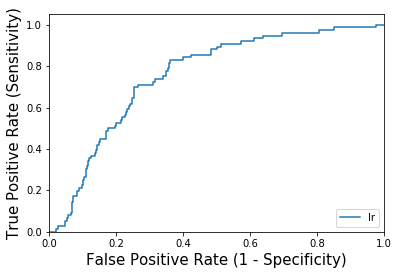

In [61]:
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y_train, y_pred_prob[:,1])
# plot LR model ROC curves
plt.plot(fpr_lr, tpr_lr,label="lr")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize = 15)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 15)

Text(0, 0.5, 'True Positive Rate (Sensitivity) or Class 1 Threshold Probability')

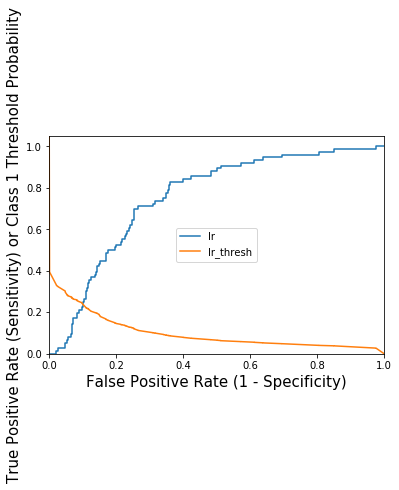

In [62]:
# plot LR and RF model ROC curves
plt.plot(fpr_lr, tpr_lr,label="lr")
plt.plot(fpr_lr,thresholds_lr, label="lr_thresh")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="center")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize= 15)
plt.ylabel('True Positive Rate (Sensitivity) or Class 1 Threshold Probability', fontsize = 15)

No handles with labels found to put in legend.


Text(0, 0.5, 'Precision')

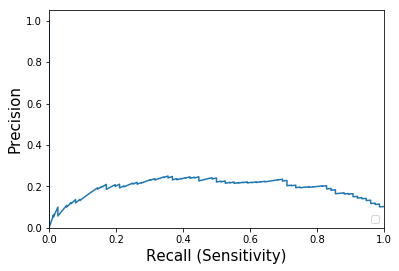

In [66]:
# calculate precision-recall curve
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_pred_prob[:,1])
plt.plot(recall, precision, label='')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")
plt.xlabel('Recall (Sensitivity)', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)

In [ ]:
dumb_model = DummyClassifier(strategy='most_frequent')
dumb_model.fit(X_train, y_train)
y_dumb_class = dumb_model.predict(X_test)
print("Most frequent class dummy classifier test accuracy: ",metrics.accuracy_score(y_test, y_dumb_class))

In [ ]:
lr_cv = LogisticRegression(random_state=0)
lr_cv.fit(X_train, y_train)
y_pred = lr_cv.predict(X_test)
y_test.value_counts()

In [ ]:
annot_features_full_low = annot_features_full[(annot_features_full['Annotation'] == 'low slug') | (annot_features_full['Annotation'] == 'low multi') | (annot_features_full['Annotation'] == 'noise') | (annot_features_full['Annotation'] == 'rand_noise')]
annot_features_full_low.head()

In [ ]:
annot_labels_low = annot_features_full_low['Annotation']
annot_labels_low.replace(regex={r'low slug': 1, 'low multi': 1, 'noise': 0, 'rand_noise': 0}, inplace=True)
annot_labels_low.head()

In [ ]:
annot_features_low = annot_features_full_low[['power_sum', 'spec_pur', 'spec_cent']]
annot_features_low.head()

In [ ]:
# center and scale the data
scaler = StandardScaler()
features_scaled_low = scaler.fit_transform(annot_features_low)

skf = StratifiedKFold(n_splits=5)
lr_cv = LogisticRegressionCV(random_state=0, cv = skf)

lr_cv.fit(features_scaled_low, annot_labels_low)

print("Test set accuracy of LR model: ",lr_cv.score(features_scaled_low, annot_labels_low))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

lr_cv = LogisticRegression(random_state=0)

y_pred = cross_val_predict(lr_cv, features_scaled_low, annot_labels_low, cv=3)
conf_mat = confusion_matrix(annot_labels_low, y_pred)
conf_mat

In [ ]:
k_range = range(2,10)
scores = []
for k in k_range:
    print(k)
    km_ss = KMeans(n_clusters=k, random_state=19)
    km_ss.fit(features_scaled)
    scores.append(silhouette_score(features_scaled, km_ss.labels_))
    print(scores)

# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')

Try only predicting low USVs

In [ ]:
annot_features_low = annot_features_full[(annot_features_full['Annotation'] == 'low slug') | (annot_features_full['Annotation'] == 'low multi')]

In [ ]:
annot_labels = annot_features_full['Annotation']
print(annot_labels.values)
annot_labels.replace(regex={r'low slug': 1, 'high slug': 2, 'low multi': 1, 'high multi': 2, 'bbc': 3, 'noise': 0, 'rand_noise': 0}, inplace=True)
annot_labels.tail()

In [ ]:
km2 = KMeans(n_clusters=2,random_state=19)
km2.fit(features_scaled)
score = silhouette_score(features_scaled, km_ss.labels_)
annot_features_full['kmeans_2_scaled'] = [ "cluster_" + str(label) for label in km2.labels_ ]
#summary_ave.groupby('kmeans_2_scaled').mean()
print(score)

In [ ]:
annot_features_full.groupby('Annotation')['kmeans_2_scaled'].value_counts()